In [1]:
import sys
import matplotlib.pyplot as plt

In [2]:
# fetch from local path otherwise fetch from the remote path (if remote kernel is being used)
try: 
    sys.path.append('../../scripts')
    import spark
    import database
except:
    try:
        sys.path.append('./scripts')
        import spark
        import database
    except:
        raise RuntimeError('Failed to import from both local and remote paths. Program terminated.')

In [3]:

spark = spark.setup_spark_session(app_name='Insert Data into MongoDB')

In [4]:
db, mongo = database.setup_database()

In [5]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
# Define the schema
schema = StructType([
    StructField('target', IntegerType(), True),
    StructField('text', StringType(), True),
])

In [6]:
df = spark.read.csv("hdfs://localhost:54310/user/datascience/data/processed/tweets_preprocessed", header=False, schema=schema, sep="\t")

Check the null / empty values 

In [7]:
null_values = df.filter(df['text'].isNull()).count()
empty_values = df.filter(df['text'] == '').count()

print(f'Number of null values: {null_values}')
print(f'Number of empty values: {empty_values}')

Number of null values: 7962
Number of empty values: 0


In [8]:
# Remove the null values
filtered_df = df[df['text'].isNotNull()]

rows = df.count()
filtered_rows = filtered_df.count()
print(f'{rows - filtered_rows} tweets were removed out of {rows}.')

7962 tweets were removed out of 1600000.


In [9]:
# check the values of the unique labels
filtered_df.groupBy('target').count().toPandas()

,target,count
0,1,795701
1,0,796337


Since class 0 is more than class 1 so perform under sampling in class 0

In [10]:
# under sampling in class 0
class_0 = filtered_df[filtered_df['target'] == 0]
class_1 = filtered_df[filtered_df['target'] == 1]
ratio =  class_1.count() / class_0.count()
resampled_class_0 = class_0.sample(withReplacement=False, fraction=ratio, seed=1)
resampled_df = class_1.union(resampled_class_0)

In [11]:
# check the values that if the classes are balanced or not
resampled_df.groupBy('target').count().toPandas()

,target,count
0,1,795701
1,0,795721


Since the above difference between two classes is quite small, so we can consider this dataset to be balanced

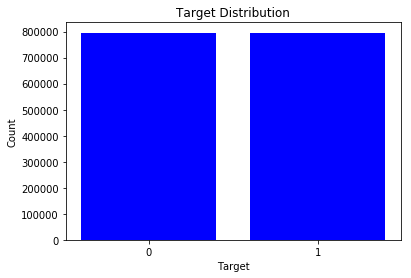

In [12]:
target_df = resampled_df.groupBy('target').count().toPandas()

plt.bar(target_df['target'], target_df['count'], color=['blue'])
plt.xticks([0, 1])
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Target Distribution')
plt.show()

In [13]:
resampled_df.limit(2).show(truncate=False)

+------+---------------------------------------------+
|target|text                                         |
+------+---------------------------------------------+
|1     |love u guy r best                            |
|1     |im meet one besti tonight cant wait girl talk|
+------+---------------------------------------------+



In [14]:
# randomly subssample the data to work on the manageable size in the sandbox environment
number_of_samples = 100000
total_samples = resampled_df.count()
ratio = number_of_samples / total_samples
mongodb_sample_df = resampled_df.sample(withReplacement=False, fraction=ratio, seed=1)

In [15]:
# Rows in the sample
print(f'Number of rows in the mongodb sample: {mongodb_sample_df.count()}')

Number of rows in the mongodb sample: 100745


In [16]:
collection_name = "tweets"

# Drop the existing collection if it exists
if collection_name in db.list_collection_names():
    db[collection_name].drop()

In [17]:
# Convert PySpark DataFrame to a list of dictionary where each dictionary represents a row in the DataFrame
# and the keys of the dictionary represent the column names
data = mongodb_sample_df.toPandas().to_dict(orient='records')

# print first 3 records to check the format
for i in range(2):
    print(data[i])

{'target': 1, 'text': 'thank twitter add sunisa got meet hin show dc area sweetheart'}
{'target': 1, 'text': 'ad tweeti new iphon'}


In [18]:
# Insert the dictionary into the collection named "tweets"
db[collection_name].insert_many(data)

In [20]:
# Check whether the data has been inserted into the collection
records =  db[collection_name].find().limit(2)
for record in records:
    print(record)

{'_id': ObjectId('6623a0c4d8a4ade911185691'), 'target': 1, 'text': 'thank twitter add sunisa got meet hin show dc area sweetheart'}
{'_id': ObjectId('6623a0c4d8a4ade911185692'), 'target': 1, 'text': 'ad tweeti new iphon'}


In [21]:
# Save the final preprocessed data to HDFS
resampled_df.write.csv(path='hdfs://localhost:54310/user/datascience/data/processed/final_tweets_preprocessed', mode='overwrite', header=False, sep="\t")

In [22]:
# Stop the spark session
spark.stop()

# Close the database connection
mongo.close()